# Causality and Experimentation Cheatsheet

This cheatsheet includes different theoretical concepts along with useful formulas.

## ANOVA Basics

In {doc}`lecture2_simpson_confounding`, we firstly mentioned **Analysis of Variance (ANOVA)** as one possible **A/B testing** approach. **ANOVA** is just one specific class of Ordinary Least-squares (OLS) model (**a continuous response versus a categorical and nominal regressor**). That said, **ANOVA** can also be used in **A/B/n testing** (i.e., a experiment with more than two treatments). 

We will explore experimental terminology via an example.

### The Website Dataset

In your **A/B/n testing**, the next $n = 72$ visitors to your website will get assigned to a random version that varies in six possible ways according to combinations of the following variables:

- `Font`: A **factor-type** variable with three levels (`small`, `medium`, and `large`).
- Button `Colour`: A **factor-type** variable with two levels (`Red` and `Blue`).

Your outcome of interest $Y$ is the **continuous** `Duration` of the visit recorded for each visitor in minutes. The experimental data is contained in `AB_data`.

In [1]:
library(tidyverse)
library(broom)
options(repr.matrix.max.rows = 14, repr.plot.height = 10, repr.plot.width = 20)

ABn_data <- read_csv("../data/ABn_data.csv", show_col_types = FALSE)
ABn_data <- ABn_data %>%
   mutate(Colour = as.factor(Colour), Font = as.factor(Font))

── Attaching core tidyverse packages ────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
ABn_data

Duration,Colour,Font
<dbl>,<fct>,<fct>
90,Red,Small
95,Red,Large
107,Red,Medium
92,Red,Small
89,Red,Large
92,Red,Medium
81,Red,Small
⋮,⋮,⋮
114,Blue,Medium


### Experimental Terminology

The field of Design and Analysis of Experiments has some **key jargon** we need to learn. In the context of this problem, we will introduce some experimental design terminology.

Note that each subgroup of visitors sees one version of the website (**all possible six pairwise combinations** of `Small`/`Medium`/`Large` fonts and `Blue`/`Red` button colours). Therefore, let us make a list of experimental characteristics:

- The variables `Font` and `Colour` are called **experimental factors**.
- We consider an experiment with six **treatments** (i.e., the six possible pairwise level combinations of `Font` and `Colour`). This characteristic makes our experiment an **A/B/n testing** (more than two treatments!).

- Each visitor is called an **experimental unit**.
- Since we have more than one **experimental unit** by **treatment**, the experiment involves **replicates** (**$72 / 6 = 12$ per treatment**).
- Because the same number of **experimental units** is assigned to each treatment, the experiment is **balanced**.
- The **experimental units** were **randomized** to either one of the six **experimental treatments**.

- All six possible combinations of factor levels were used, so the experimental design is called a **full factorial** design.
- We might specifically call this a $2 \times 3$ **full factorial** design, since there are two factors (`Colour` with two levels and `Font` with three levels).

### Two-way ANOVA with main effects only

We will proceed with some statistical modelling. The first model is called a **two-way ANOVA with main effects only**. 

```{important}
A **main effect** refers to a standalone regressor in our model.
```

In **experimental notation**, the response $Y_{i, j, k}$ for the $i$th `Font` level, the $j$th `Colour` level, and the $k$th **experimental unit** is decomposed as:

$$Y_{i,j,k} = \mu_{i} + \tau_{j} + \varepsilon_{i, j, k},$$

where:

- $\mu_i$ is the main effect on the mean response of the $i$th `Font` level (for $i = 1, 2, 3$),
- $\tau_{j}$ is the main effect on the mean response of the $j$th `Colour` level (for $j = 1, 2$), and 
- $\varepsilon_{i, j, k}$ is the error component assumed as independent, normally distributed, with mean zero and common variance $\sigma^2$ (for $k = 1, \dots, 12$).

We can fit this model with the `lm()` function.

In [3]:
# Releveling factors according to the control treatment
ABn_data$Colour <- fct_relevel(
  ABn_data$Colour,
  c("Blue", "Red")
)
ABn_data$Font <- fct_relevel(
  ABn_data$Font,
  c("Small", "Medium", "Large")
)

In [4]:
OLS_ABn_main_effects <- lm(formula = Duration ~ Font + Colour, data = ABn_data)
tidy(OLS_ABn_main_effects, conf.int = TRUE) %>% mutate_if(is.numeric, round, 2)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),103.64,3.32,31.20,0.00,97.01,110.27
FontMedium,12.75,4.07,3.13,0.00,4.63,20.87
FontLarge,7.67,4.07,1.88,0.06,-0.45,15.78
ColourRed,-21.44,3.32,-6.46,0.00,-28.07,-14.82


The above `tidy()` output only sheds light on the fact that the **medium** `Font` and **red** `Colour` are statistically significant with $\alpha = 0.05$ to the baseline levels (**small** and **blue**). Nonetheless, we might better use an **ANOVA table**. 

```{important}
**ANOVA tables** go hand-in-hand with randomized experiments. **They are helpful to organize regression fits to factorial experiment data.** The table decomposes the **sum of squares** (i.e., variability) for each **experimental factor**. To obtain these tables, we can use the function `anova()`.
```

In [5]:
anova(OLS_ABn_main_effects) %>% mutate_if(is.numeric, round, 2)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Font,2,1977.44,988.72,4.98,0.01
Colour,1,8277.56,8277.56,41.69,0.00
Residuals,68,13501.44,198.55,NA,NA


The previous table will allow us to test the following **composite hypotheses** (i.e., we test more than one parameter at the same time) by **experimental factor**:

`Font`

```{math}
\begin{gather*}
H_0\text{: } \mu_1 = \mu_2 = \mu_3 \\
H_a\text{: at least one pair } \mu_u \neq \mu_v \text{ with } u \neq v.
\end{gather*}
```

`Colour`

```{math}
\begin{gather*}
H_0\text{: } \tau_1 = \tau_2 \\
H_a\text{: } \tau_1 \neq \tau_2.
\end{gather*}
```

With $\alpha = 0.05$, we can state that at least one pair of factor levels in `Font` is statistically different in terms of their mean responses. In the case of `Colour`, its two levels are statistically different in terms of their mean responses.

### Two-way ANOVA with interactions

As a **general experimental guideline**, we should consider the potential for **interactions** with two or more factors. A **two-factor interaction plot** will give us a graphical insight into a statistically significant interaction.

```{important}
A **two-factor interaction plot** has the continuous outcome of interest on the $y$-axis and the **first factor** levels on the $x$-axis. The plot illustrates lines whose nodes correspond to mean responses by factor level. We can also plot error bars by a node. There will be as many coloured lines as levels in the **second factor**.
```

In [6]:
options(repr.plot.height = 8, repr.plot.width = 14)

ABn_int_plots <- ABn_data %>% 
  ggplot(aes(x = Font, colour = Colour, group = Colour, y = Duration)) +
  stat_summary(fun = mean, geom = "point", size = 5) +
  stat_summary(fun = mean, geom = "line") +
  stat_summary(fun.data = mean_se, geom = "errorbar", width = 0.1) +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21),
    legend.position = "bottom",
    legend.title = element_text(size = 21, face = "bold", margin = margin(r = 1, unit = "cm")), 
    legend.text = element_text(size = 17, margin = margin(r = 1, unit = "cm"))
  ) +
  ggtitle("Interaction Plots") +
  xlab("Font") +
  ylab("Visit Duration (min)") + 
  scale_color_manual(values = c("blue", "red"))

The interaction plot below corresponds to our case study. A graphical interaction will occur if one factor level (`Font`) differs by the level of the other factor (`Colour`) **while the lines cross**.

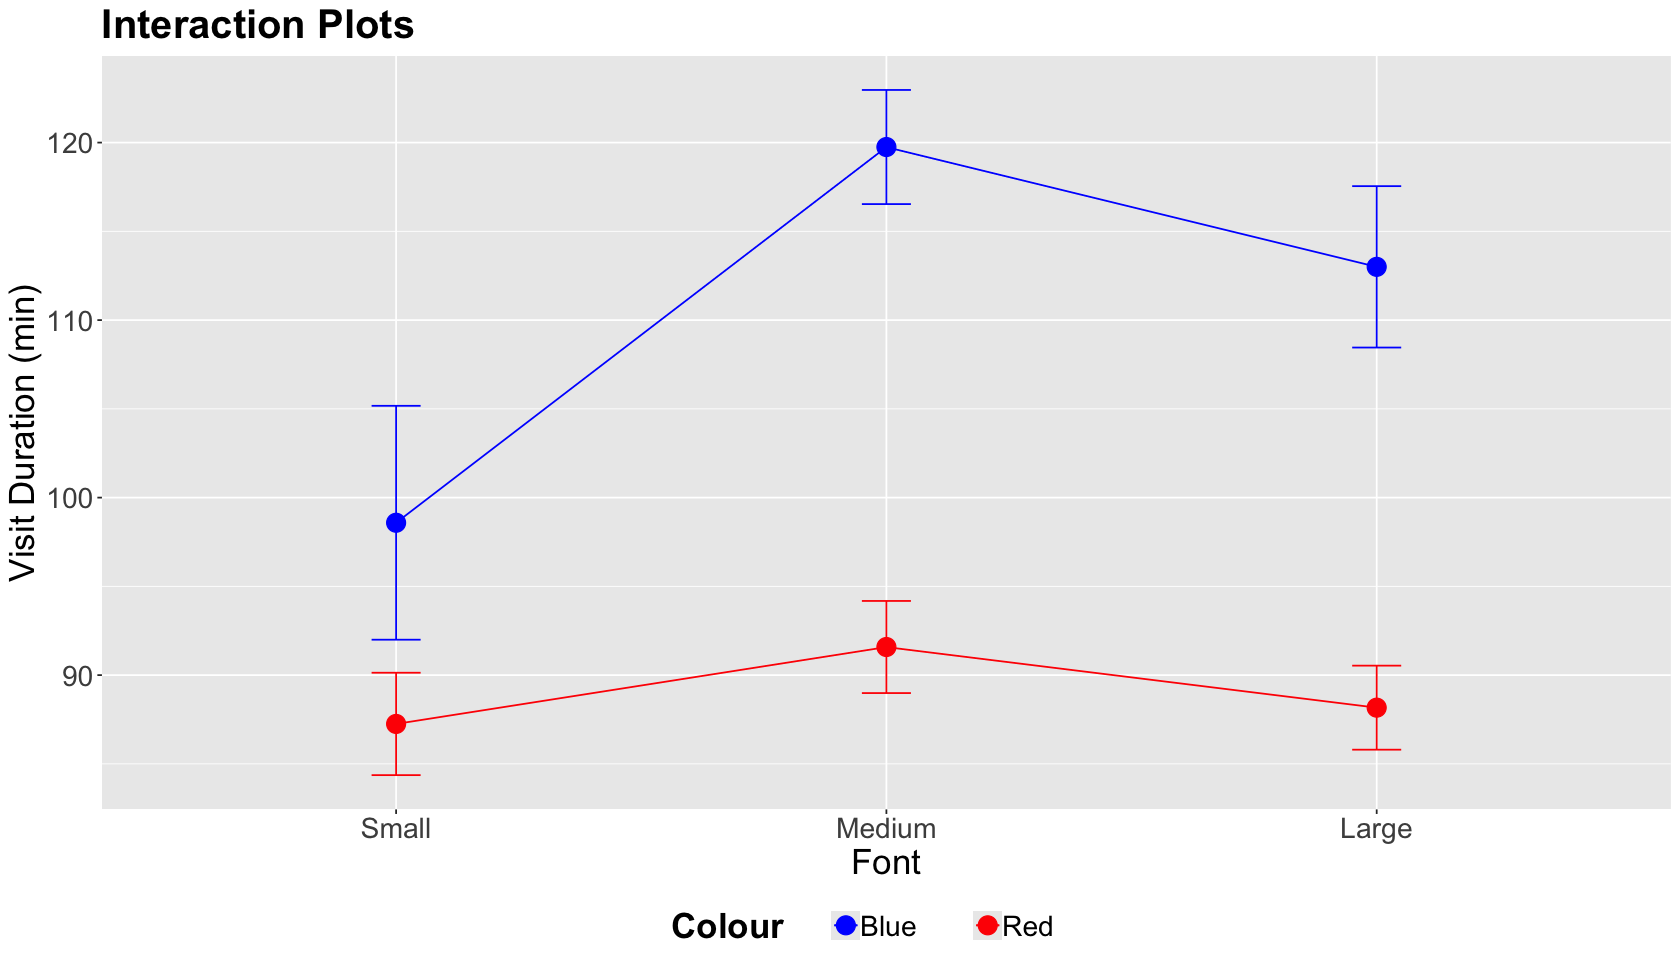

In [7]:
ABn_int_plots

In this case, the lines by `Colour` level do not cross while we vary `Font` sizes. Hence, **we do not have graphical evidence of a two-factor interaction**.

Now let us confirm the previous graphical result by fitting an OLS model that includes an interaction term, as shown below. This model is called a **two-way ANOVA with interaction effects**. This model includes both **main effects** and **two-factor interaction terms**. In **experimental notation**, the response $Y_{i, j, k}$ for the $i$th `Font` level, the $j$th `Colour` level, and the $k$th **experimental unit** is decomposed as:

$$Y_{i,j,k} = \mu_{i} + \tau_{j} + (\mu \tau)_{i, j} + \varepsilon_{i, j, k},$$

where:

- $\mu_i$ is the main effect on the mean response of the $i$th `Font` level (for $i = 1, 2, 3$), 
- $\tau_{j}$ is the main effect on the mean response of the $j$th `Colour` level (for $j = 1, 2$), 
- $(\mu \tau)_{i, j}$ is the interaction effect of both factors on the mean response of the $i$th and $j$th levels, and 
- $\varepsilon_{i, j, k}$ is the error component assumed as independent, normally distributed, with mean zero and common variance $\sigma^2$ (for $k = 1, \dots, 12$).

```{caution}
The term $(\mu \tau)_{i, j}$ **DOES NOT** indicate that the main effects are multiplying each other. Mathematically, it is **another** modelling term.
```

We use `Duration ~ Colour * Font` as a `formula` argument in `lm()`.

In [8]:
OLS_ABn_interaction <- lm(formula = Duration ~ Colour * Font, data = ABn_data)
tidy(OLS_ABn_interaction) %>% mutate_if(is.numeric, round, 2)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),98.58,3.98,24.77,0.00
ColourRed,-11.33,5.63,-2.01,0.05
FontMedium,21.17,5.63,3.76,0.00
FontLarge,14.42,5.63,2.56,0.01
ColourRed:FontMedium,-16.83,7.96,-2.11,0.04
ColourRed:FontLarge,-13.50,7.96,-1.70,0.09


Again, the `tidy()` output might not be entirely informative. Hence, we use the function `anova()` to obtain the **ANOVA table** for this interaction model.

In [9]:
anova(OLS_ABn_interaction) %>% mutate_if(is.numeric, round, 2)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Colour,1,8277.56,8277.56,43.54,0.00
Font,2,1977.44,988.72,5.20,0.01
Colour:Font,2,953.44,476.72,2.51,0.09
Residuals,66,12548.00,190.12,NA,NA


The previous table will allow us to test the same **composite hypotheses** for the previous main effects plus the ones corresponding to the **two-factor interaction terms**:


```{math}
H_0\text{: } (\mu \tau)_{1, 1} = (\mu \tau)_{1, 2} = (\mu \tau)_{2, 1} = (\mu \tau)_{2, 2} = (\mu \tau)_{3, 1} = (\mu \tau)_{3, 2} \\
H_a\text{: at least one pair } (\mu \tau)_{u, v} \neq (\mu \tau)_{u', v'}.
```

The null hypothesis indicates that all interaction terms are on the status quo.

With $\alpha = 0.05$, we have evidence to reject the null hypotheses for the main effects **but not for the interaction effects**. Hence, any specific interaction (among the six possible ones) **DOES NOT** stand out as statistically significant.

```{admonition} Interlude: Counting parameters for main effects and two-factor interactions
:class: hint
The column `Df` in the **ANOVA table** represents the degrees of freedom for each class of modelling term. In a **two-way ANOVA with interaction effects**, if factor 1 has $p_{1}$ levels and factor 2 has $p_{2}$ levels then:

- $p_1 - 1$ degrees of freedom are needed for the main effect of factor 1.
- $p_2 - 1$ degrees of freedom are needed for the main effect of factor 2.
- $(p_1 - 1) \times (p_2 - 1)$ degrees of freedom are needed for the interaction between factor 1 and factor 2.
```

### Post-Hoc Tests

Recall our main statistical inquiry:

> **What experimental treatment maximizes the `Duration` of the visit?** Suppose the **control treatment** corresponds to the **small font and blue colour**.

We will use the **two-way ANOVA with interaction effects** to answer this. However, we have only been able to answer whether the main or interaction effects are statistically significant or not **in general**. Therefore, we need to run **post-hoc tests**.

```{important}
The term "post hoc" means "after this" in Latin. A **post hoc test** in this class of experimental models refers to **all possible pairwise comparisons among the levels of the main and interactions effects after the model is estimated**. This matter involves **multiple testing corrections.**
```

As discussed in {doc}`lecture1_multiple_comparisons`, there is more than one multiple testing correction method. The same situation applies in ANOVA models. We will use the **Tukey's honestly significant differences (HSD)**. 

```{attention}
Tukey's HSD keeps the **family-wise error rate (FWER)** at $\alpha$ or below. **This method is only designed for ANOVA models.**
```

We will use the function `TukeyHSD()` to run this method. The function needs an `aov()` object as an input. **Function `aov()` is just an `lm()` wrapper specifically programmed for ANOVA models.** It also has `formula` and `data` arguments. The `tidy()` output is an **ANOVA table**.

```{important} 
`TukeyHSD()` function also has a `tidy()` output. We highlight the following:

- The output will show all the pairwise difference estimates (column `estimate`) among all main and interaction effect levels along with their corresponding confidence intervals (CIs) and adjusted $p$-values. 
- The column `null.value` corresponds to the hypothesized status quo difference, i.e., a difference equal to zero in $H_0$.
- An adjusted $p\text{-value} < \alpha$ indicates a statistically significant difference in a given level pair (column `contrast`) with significance level $\alpha$.
```

In [10]:
options(repr.matrix.max.rows = 20)

In [11]:
OLS_aov_ABn_interaction <- aov(formula = Duration ~ Colour * Font, data = ABn_data)
tidy(OLS_aov_ABn_interaction) %>% mutate_if(is.numeric, round, 2)

term,df,sumsq,meansq,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Colour,1,8277.56,8277.56,43.54,0.00
Font,2,1977.44,988.72,5.20,0.01
Colour:Font,2,953.44,476.72,2.51,0.09
Residuals,66,12548.00,190.12,NA,NA


In [12]:
tidy_tukey <- tidy(TukeyHSD(OLS_aov_ABn_interaction, conf.level = 0.95)) %>% mutate_if(is.numeric, round, 2)
tidy_tukey

term,contrast,null.value,estimate,conf.low,conf.high,adj.p.value
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Colour,Red-Blue,0,-21.44,-27.93,-14.96,0.00
Font,Medium-Small,0,12.75,3.21,22.29,0.01
Font,Large-Small,0,7.67,-1.88,17.21,0.14
Font,Large-Medium,0,-5.08,-14.63,4.46,0.41
Colour:Font,Red:Small-Blue:Small,0,-11.33,-27.86,5.19,0.35
Colour:Font,Blue:Medium-Blue:Small,0,21.17,4.64,37.69,0.00
Colour:Font,Red:Medium-Blue:Small,0,-7.00,-23.52,9.52,0.81
Colour:Font,Blue:Large-Blue:Small,0,14.42,-2.11,30.94,0.12
Colour:Font,Red:Large-Blue:Small,0,-10.42,-26.94,6.11,0.44


Let us focus on the **significant** difference corresponding to the two-factor interaction, **specifically that containing the control treatment blue `Colour` and small `Font` (our CONTROL treatment)**. We can see that the **largest positive estimated difference** corresponds to `Blue:Medium-Blue:Small` with $21.17$ and a 95% CI of $[4.64, 37.69]$.

In [13]:
tidy_tukey %>%
  filter(adj.p.value < 0.05 & grepl("Blue:Small", contrast))

term,contrast,null.value,estimate,conf.low,conf.high,adj.p.value
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Colour:Font,Blue:Medium-Blue:Small,0,21.17,4.64,37.69,0


**Hence, given the results of the A/B/n testing, the experimental treatment that maximizes the outcome of interest compared to the control treatment is the blue `Colour` with medium `Font`.** Note `Colour` did not make any difference but the `Font`. This fact is consistent with our interaction plot!

```{attention}
Other `aov()` post hoc tests are available through the `PostHocTest()` function via the package `DescTools`. Bonferroni correction is one of these alternative methods.
```

## Blocking

A **blocking factor** allows us to group our **experimental units** by common characteristics. Note that the experimenter does not have control over the blocking factor. **They just consider it as a grouping factor.**

These are some examples of blocking:

- Grouping the experimental units as **batches of material**.
- Grouping the experimental units by **time periods** during which the A/B testing occurs.
- Grouping our experimental units by **working shifts**.

One of the greatest statisticians who made important contributions to the field of Design and Analysis of Experiments was George E. P. Box (1919-2013). He is famous for his phrase: ["**Essentially all models are wrong, but some are useful.**"](https://rss.onlinelibrary.wiley.com/doi/pdf/10.1111/j.1740-9713.2010.00442.x) However, he also has another great phrase: "**Block what you can, randomize what you cannot.**"

```{hint}
Essentially, this phrase implicates the following:

- The **core idea** of blocking is removing the effect of secondary measurable variables from our response of interest. Hence, our statistical model could shed light on some statistical **association/causation** between the levels of a secondary blocking factor and our response of interest. 
- On the other hand, **experimental treatment** randomization takes care of other nuisance variables, which we cannot measure.
```

###  Blocking Procedure

So far, we have been discussing experiments where all of our experimental units are directly randomized to some treatment. Nevertheless, blocking involves a two-step process as follows.

1. Stratify your experimental units into homogeneous blocks. For instance, this stratification might be some relevant demographic variable in the case of human beings. Each stratum will be a block.
2. Randomize the units to the experimental treatments of interest within each block.

## Bonferroni Correction

The Bonferroni correction **conservatively** guards against $p$-hacking! The idea is simple: 

> If $m$ comparisons (hypothesis tests) are to be carried out, use significance level $\alpha/m$ for each.

### The Bonferroni Guarantee

The Bonferroni correction comes from a well-known result in probability theory known as the [**Bonferroni inequality**](https://mathworld.wolfram.com/BonferroniInequalities.html). Suppose you have $m$ hypothesis testings and in reality, for some, $H_0$ is true; and for others, $H_0$ is false. Let $R_i$ be event of rejecting the $i$th $H_0$ when in fact is true (for $i = 1, \dots, m$). The inequality is the following:

$$
P(R_1 \; \cup \; R_2 \; \cup \; \dotsc \; \cup \; R_m) \leq P(R_1) + P(R_2) + \dotsb + P(R_m).
$$

Now, this inequality will pave the way to the **family-wise error rate (FWER)**. The FWER is **the chance that one or more of the true null hypotheses are rejected**. If each comparison is made at significance level $\alpha/m$, then the FWER is guaranteed to be $\alpha$ or less.

$$
\text{FWER} \leq \sum_{k = 1}^m \frac{\alpha}{m} = \alpha.
$$

```{attention}
Note the following **punchline** from the mathematical expression above: the Bonferroni correction (i.e., $\alpha / m$) lets us guarantee that we **wrongly** reject a null hypothesis with probability less than $\alpha$.
```

### Is there a price to pay?

Let $R_j$ be event of rejecting the $j$th $H_0$ when in fact is true (for $j = 1, 2$). Hence, the Bonferroni inequality, when we only have two comparisons yielding two events $R_1$ and $R_2$, is

$$
P(R_1 \; \cup \; R_2) \leq P(R_1) + P(R_2).
$$

The above **inequality** will be **equal to $\alpha$** only when $R_1$ and $R_2$ are **mutually exclusive**! Recall that two events are mutually exclusive when:

```{math}
\begin{align*}
P(R_1  \; \cup \; R_2) &= P(R_1) + P(R_2) - \overbrace{P(R_1  \; \cap \; R_2)}^{0} \\
&= P(R_1) + P(R_2).
\end{align*}
```

The expression above indicates that the events $R_1$ and $R_2$ cannot happen at the same time since their intersection is equal to zero.

However, **what are implications on the Bonferroni correction when $R_1$ and $R_2$ could happen at the same time, i.e., $P(R_1  \; \cap \; R_2) > 0$?** We will revisit the inequality:

$$
P(R_1 \; \cup \; R_2) \leq P(R_1) + P(R_2),
$$

and the corresponding

$$
\text{FWER} \leq \frac{\alpha}{2} + \frac{\alpha}{2}  = \alpha.
$$

Since  

$$P(R_1  \; \cup \; R_2) = P(R_1) + P(R_2) - P(R_1  \; \cap \; R_2) \qquad \text{with} \qquad P(R_1  \; \cap \; R_2) > 0,$$ 

we would be penalizing the standalone probabilities $P(R_1)$ and $P(R_2)$ too much with the correction $\alpha / 2$. **This issue makes the Bonferroni correction too conservative.**

Suppose we generalize this matter to $m$ hypothesis testings, **where some of them could happen simultaneously**. In that case, this becomes a more conservative issue yielding adjusted $p$-values that are too penalized.

We might need to use an alternative tool then such as the **false discovery rate**.

## Causality in Non-randomized Studies

In many different case studies, treatment randomization is impossible to address **causality**. Hence, we need to apply certain statistical concepts and tools to address our specific inquiries.

### Example

Pharmaco-epidemiology problems and electronic health records:

- We might encounter different data pipelines for massive healthcare utilization databases to obtain knowledge about drug efficacy and safety.

## Causality in Randomized Studies

In this class of studies, the researcher can **randomly** allocate the subjects to one of the experimental treatments to address **causality**. An **experimental treatment** is a given testing strategy (e.g., in pharmaceutical trials, a **placebo** is a **control treatment** whereas the **experimental drug** is the **treatment of interest**). Specifically, in Data Science, we could encounter the example below.

### Example

A/B testing for website optimization:

- *Does a tweak to a website improve user experience and/or generate more sales?* (i.e., control **website A** versus experimental **website B**).
 - *Can we end a test early?* This is called **early-stopping** in statistical jargon.

## Confounding

Let us start by formally explaining what a *confounder* is. [Mann and Wood (2012)](https://benthamopen.com/contents/pdf/TOEPIJ/TOEPIJ-5-18.pdf) provide the following definition in a medical context:

> *In general, for a variable to be a confounder in a particular study, the formal definition requires that it must meet two criteria: the first is that it must be related to the outcome of interest in terms of prognosis or
susceptibility. The second criteria, which explains why it is more commonly seen outside the setting of RCTs, is that the distribution of the confounding factor is different in the groups being compared. **More broadly, confounding can be defined as a mixing of effects between the *exposure of interest*, the *disease*, and a third factor (i.e., the *confounder*) that is associated with the *exposure* that independently affects the risk of developing the *disease*.**

Roughly speaking, in a regresssion framework where $X$ is the regressor and $Y$ is the response, another regressor $C$ confounds the $X$-$Y$ relationship if $C$ and $X$ are associated, and $C$ and $Y$ are associated as shown in {numref}`confounding-app`.

```{figure} ../img/confounding.png
:height: 300px
:name: confounding-app

Diagram of Confounding.
```

### Strategies to Deal with Confounding

There is more than one way to deal with confounding if we want to detect a causal relationship between $X$ and $Y$. Depending on the nature of the study, one could do the following:

1. In the case of observational studies, **stratification** is a good strategy. It implies checking the association between $X$ and $Y$ within subgroups of observations that share common values for the confounders. In a linear regression context with $m$ confounders $C_j$, we would regress $Y$ on $X$ **and** $C_1, C_2, \dots, C_m$.

2. In an experimental study, such as A/B testing, we would randomize each subject to a particular level of factor $X$. Then, we compare $Y$ across the different levels of $X$. For instance, one could use an **Analysis of Variance (ANOVA)**, which is just one specific class of OLS model (**a continuous response versus a categorical and nominal regressor**).

```{important}
The second strategy is the golden standard in causal inference and design and analysis of experiments. Nonetheless, it might implicate different statistical, practical, and ***ETHICAL*** matters.
```

```{admonition} What is the beauty of a randomized experiment?
:class: hint
The regressor $X$ is **guaranteed** to be independent of all possible confounders! Whether or not you can measure these confounders, or even know the identity of each $C_j$.

Thus, we no longer need to be concerned with confounding, and **we can interpret the association between $X$ and $Y$ in a causal manner**.
```

## False Discovery Rate

Suppose someone tells you they did a given hypothesis test using some data and got a $p\text{-value} = 0.023$. **In isolation, you do not know whether to be impressed or not!** You need some information about how much "hunting" was done to find this result. 

Moreover, there is a trade-off between types of error: **false discoveries** (i.e. false positives!) and **missing real effects** (i.e. false negatives!). Depending on the situation/goals, one might be preferable to the other.

### A Simple Thought Experiment 

Let us consider a simple thought experiment:

- Assume there is an ensemble of research studies on different scientific questions.
- Moreover, suppose that every study in the ensemble did a good job of type I (false positive) error control.
- Finally, there was only one comparison per study such that:

$$P(\text{reject null} \mid \text{null is true}) = 0.05$$

There is an available method to control the **expected proportion of false positives** (i.e., type I error) from all this ensemble of research studies. This is what we call the **false discovery rate (FDR)**.

Unlike FWER, **FDR is less strict** because it controls for this expected proportion of false positives instead of the probability of producing *at least* one false positive.

### Benjamini-Hochberg

Suppose you have $m$ hypothesis testings. The method has four steps:

1. Specify a **maximum tolerable FDR**, $\delta$.
2. Sort the $m$ p-values from lowest to highest (most significant to least): 

$$p_{(1)} \leq p_{(2)} \leq p_{(3)} \leq \dots \leq p_{(m)}$$

3. Let $k^*$ be the biggest $k$ for which $p_{(k)} < (\delta / m) k$
4. Take $p_{(1)}, \dots, p_{(k^*)}$ as your **significant** findings.

Let us illustrate this procedure with the following raw $p$-values:

In [14]:
raw_pvalues <- c(
  0.0010, 0.0070, 0.0110, 0.0307, 0.1096,
  0.2612, 0.4018, 0.5828, 0.7161, 0.9628
)

The previous four steps are shown in the table below. Using BH, with $\delta = 0.05$, we label $0.0010$, $0.0070$, and $0.0110$ as statistically significant via $k^* = 3$.

```{figure} ../img/table1_FDR.png
:height: 350px
:name: table1_FDR
```

We graphically show the previous BH example below, where each point represents an ordered $p$-value. Note the cutoff value is at $k^* = 3$ (vertical dashed blue line) while the red line corresponds to $(\delta / m) k$ with $\delta = 0.05$ and $m = 10$.

In [15]:
library(tidyverse)

options(repr.plot.height = 8, repr.plot.width = 14)

pvalues <- data.frame(raw_pvalues, k = seq_along(raw_pvalues)) %>%
  mutate(bh_line = 0.05 / nrow(.) * k)

FDR_plot <- ggplot(pvalues, aes(x = factor(k), y = raw_pvalues)) +
  geom_point() +
  geom_line(aes(x = k, y = bh_line), colour = "red") +
  xlab("k") +
  ylab("p(k)") +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21),
    legend.position = "none"
  ) +
  geom_vline(xintercept = 3, colour = "darkblue", linetype = "dashed") +
  ggtitle("BH Example")

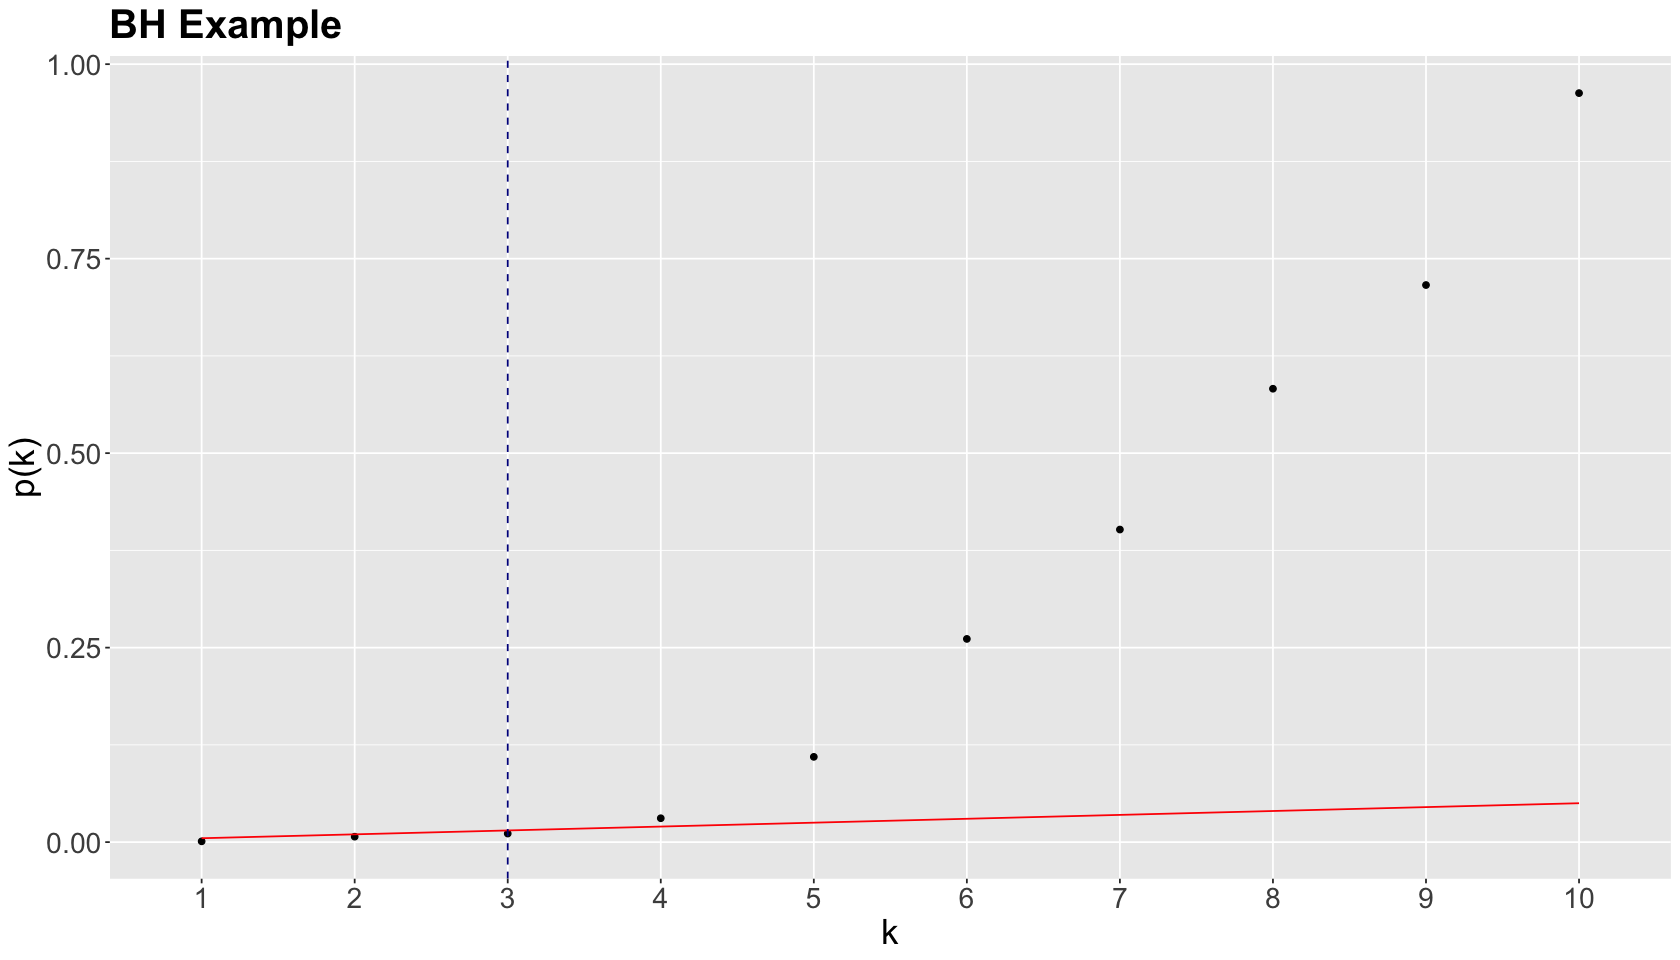

In [16]:
FDR_plot

As in the case of the Bonferroni correction, we can obtain **BH adjusted $p$-values** as

$$\text{BH adjusted } p\text{-value}_i = \min \Big\{ \frac{p\text{-value}_i \times m}{i}, \text{BH adjusted } p\text{-value}_{i + 1} \Big\},$$

where:

- $i$ is the rank of the raw $p$-value.
- $m$ is the number of tests.

```{figure} ../img/table2_FDR.png
:height: 350px
:name: table2_FDR
```

We can obtain the BH adjusted $p$-values via `p.adjust()` as we can see below.

In [17]:
round(p.adjust(raw_pvalues, method = "fdr"), 4)

[1] 0.0100 0.0350 0.0367 0.0768 0.2192 0.4353 0.5740 0.7285 0.7957 0.9628

By checking these adjusted $p$-values, using a **maximum tolerable FDR** $\delta = 0.05$, we would label the first three values (from left to right) as statistically significant.

If we want to be even less conservative, i.e. increasing $\delta$ to 0.10, we would label the first four values as statistically significant.

The table below shows different BH critical values by $\delta = 0.05, 0.10, 0.20$.

```{figure} ../img/table3_FDR.png
:height: 350px
:name: table3_FDR
```

## Hypothesis Testing Basics

In statistical inference, we have **two hypotheses**: the **null** $H_0$ and the **alternative** $H_a$. 

$H_0$ represents the status quo in our case study, whereas $H_a$ represents our hypothesis of interest. Furthermore, recall there are two types of errors shown in the table below.

|  |  **$H_0$ is true** |  **$H_0$ is not true** |
|:--------------------------------------------------------------------------------------------:|:------------------:|:----------------------:|
|                                   **Fail to reject $H_0$**                                   |       Correct (**TRUE NEGATIVE**)     |      Type II Error (**FALSE NEGATIVE**)     |
|                                       **Reject $H_0$**                                       |    Type I Error (**FALSE POSITIVE**)    |         Correct (**TRUE POSITIVE**)        |

These errors are I (**false positive**) and II (**false negative**). Their setup is targeted towards rejecting or not rejecting $H_0$, given that $H_0$ is true or not. Moreover, these errors are measured in **probabilities**.

The **frequentist hypothesis testing process** is the following:

1. We need to set up a pre-specified significance level (usually $\alpha = 0.05$). The significance level $\alpha$ will be our tolerance to type I error: **rejecting the null hypothesis when in fact is true**. 
2. Compute a **test statistic** from our sampled data. This test statistic will have a **sampling distribution** under $H_0$.
3. Compare the test statistic against **a certain quantile threshold under $H_0$**, then:

    - Reject $H_0$ in favour of $H_a$ if the test statistic **exceeds** this quantile threshold under $H_0$.
    - Do not reject $H_0$ otherwise.

```{attention} 
The quantile threshold is chosen such that 

$$P(\text{reject null} \mid \text{null is true}) = \alpha.$$
```

### $p$-value

An **alternative way** of performing **Step 3** is computing the $p$-value associated to the test statistic under $H_0$. For this **Step 3**, **in general** let the test statistic be $T$ (**note the random variable notation as an uppercase!**) and the quantile threshold $c_\alpha$. Thus, we would reject $H_0$ if

$$T \geq c_\alpha.$$

Now, for our **observed** data, the test statistic will be $t_{\text{obs}}$ (**note the lowercase notation!**). In probability notation, the $p$-value can be represented as:

$$p\text{-value} = P\left(T \geq t_{obs} \mid \mbox{null is true}\right).$$

```{attention}
The $p$-value is the chance of getting a test statistic as or more extreme than what you actually got as **observed data**, presuming $H_0$ is true. **We will reject $H_0$ if**

$$p\text{-value} < \alpha.$$
```

### Graphical Overview of the Hypothesis Testing

All the previous process can also be put as in the diagram below.

```{figure} ../img/classical-test-framework.png
:height: 300px
:name: classical_hypothesis_b_app

Workflow of a theory-based hypothesis testing.
```

### Type I Error ($\alpha$)

We commit this error if we reject $H_0$ when in fact, it is true for the population of interest. It is identified as $\alpha$, i.e., the significance level in our hypothesis testing. This is the main reason why we use the rule of $p\text{-value} < \alpha$ in our testing conclusion to reject $H_0$: **it is in our best interest to control (and minimize!) this error**. Again, recall the hypothesis testing is developed under a null framework.

### Type II Error ($\beta$)

Now, we introduce the type II error. We commit type II error if we fail to reject $H_0$, when in fact, it is **not** true for the population. It is identified as $\beta$. This class of error has a particular role in our hypothesis testing since it is part of **Power Analysis** in what we call the power of test $1 - \beta$. It is the power of our test that could break the status quo denoted by our null model.

```{attention}
Interestingly, maximizing the power of the test implicates pulling more than one string.
```

### The Power of the Test

This is $1 - \beta$, the **true positive** or correctly rejecting $H_0$. The key aspects to maximize the power of the test are the following:

- **Sample size.** The larger the sample size $n$, the larger the power of the test. This guideline sounds easy to follow, but it is not when we have limited sampling resources.
- **Significance level.** The larger the significance level $\alpha$, the larger the power of the test. Nevertheless, this implies a test more prone to committing Type I error!
- How far are the population parameters of interest between the null and alternative models? This is related to what we call the **effect size**. For instance, in our so-called A/B testing example, the **effect size** implicates how much we aim to increase the click-through rates (CTRs) between the **control** and **experimental** treatment.

#### Pulling different strings in the power of a test!

Let us set an example on which we can verify what we mean by pulling different strings to obtain the power of the test.

Suppose we are interested in inferring the **population mean height $\mu$ in meters** of adults identified as male (between 21 and 30 years old) in Mexico City. **Previous studies** have concluded that the population mean is around $1.70$m (for the practical purpose of the null model: $\color{blue}{\mu = 1.70}$). Nonetheless we hypothesize that $\color{red}{\mu > 1.70}$. Therefore:

$$\color{blue}{H_0: \mu = 1.70}$$
$$\color{red}{H_a: \mu > 1.70}$$

Note we color in <font color='blue'>blue</font> all those elements belonging to our null model, whereas in <font color='red'>red</font> those ones for our alternative model. Furthermore, in our hypothesis testing, we will use the sample mean $\bar{X}$ as our **estimator**.

**Without loss of generality**, let us work under a classical theory-based approach. Assume we have an **incredibly well-behaved estimator**, i.e., the approximate sampling distribution of $\bar{X}$ is supported by the Central Limit Theorem (CLT) **with a large enough sample size $n$**. Moreover, suppose we know the real population standard deviation $\sigma$.

Hence: 

$$\bar{X} \mathrel{\dot\sim} \mathcal{N} \Bigg( \mu, \frac{\sigma}{\sqrt{n}} \Bigg) \quad \text{as} \quad n \rightarrow \infty$$

Let us check different scenarios given this framework.

```{attention}

Symbol $\mathrel{\dot\sim}$ means "*is approximately distributed as*".
```

#### Baseline Scenario

We have the following hypotheses:

$$\color{blue}{H_0: \mu = 1.70}$$
$$\color{red}{H_a: \mu > 1.70}$$


```{attention} 
For this scenario, and subsequent ones, assume that <font color='red'>$H_a$ is true in fact for the population</font>, **but we do not know it beforehand in real life**. That is why we are performing statistical inference via a random sample!
```

Moreover, let us define the <font color='red'>alternative model</font> for the sampling distribution of $\bar{X}$ as: 

$$\color{red}{\bar{X} \mathrel{\dot\sim} \mathcal{N} \Bigg( \mu = 1.75, \frac{\sigma}{\sqrt{n}} \Bigg) \quad \text{as} \quad n \rightarrow \infty}$$

versus the <font color='blue'>null model</font>

$$\color{blue}{\bar{X} \mathrel{\dot\sim} \mathcal{N} \Bigg( \mu = 1.70, \frac{\sigma}{\sqrt{n}} \Bigg) \quad \text{as} \quad n \rightarrow \infty}$$

As additional assumptions, let us set a population $\sigma = 0.2 \text{ m}$ (**for both models**) and a sample size $n = 50$.

Function `plotting_power_function()` will provide the corresponding null and alternative distributions under each set of scenario parameters. Let us focus on the plots and not the coding syntax.

In [18]:
options(repr.plot.height = 8, repr.plot.width = 14)

library(tidyverse)
library(ggplot2)
library(cowplot)

plotting_power_function <- function(mean_null, mean_alt, sd, n, alpha_level, x_coord, x_coord_2,
                                    y_coord_alpha, y_coord_power) {
  data_null <- tibble(
    x = seq(mean_null - 3.5 * (sd / sqrt(n)), mean_null + 3.5 * (sd / sqrt(n)), 0.0001),
    f_null = dnorm(x, mean = mean_null, sd = sd / sqrt(n))
  )

  data_alternative <- tibble(
    x = seq(mean_alt - 3.5 * (sd / sqrt(n)), mean_alt + 3.5 * (sd / sqrt(n)), 0.0001),
    f_alternative = dnorm(x, mean = mean_alt, sd = sd / sqrt(n))
  )

  power <- round(pnorm(
    q = qnorm(1 - alpha_level, mean = mean_null, sd = sd / sqrt(n)),
    mean = mean_alt, sd = sd / sqrt(n), lower.tail = FALSE
  ), 3)

  plot_power <- data_null %>%
    ggplot() +
    geom_line(aes(x, f_null), colour = "blue") +
    geom_line(data = data_alternative, aes(x, f_alternative), colour = "red") +
    geom_segment(aes(x = x, y = 0, xend = x, yend = dnorm(x, mean = mean_null, sd = sd / sqrt(n))),
      color = "blue",
      data = data_null %>% filter(x >= qnorm(1 - alpha_level, mean = mean_null, sd = sd / sqrt(n))), alpha = 0.05
    ) +
    geom_vline(xintercept = qnorm(1 - alpha_level, mean = mean_null, sd = sd / sqrt(n)), linetype = "dashed", color = "blue") +
    geom_segment(aes(x = x, y = 0, xend = x, yend = dnorm(x, mean = mean_alt, sd = sd / sqrt(n))),
      color = "red",
      data = data_alternative %>% filter(x >= qnorm(1 - alpha_level, mean = mean_null, sd = sd / sqrt(n))), alpha = 0.05
    ) +
    geom_vline(xintercept = mean_null, linetype = "solid", color = "blue") +
    geom_vline(xintercept = mean_alt, linetype = "solid", color = "red") +
    geom_hline(yintercept = 0) +
    theme(
      axis.title.y = element_blank(),
      axis.text.y = element_blank(),
      axis.ticks.y = element_blank(),
      plot.title = element_text(face = "bold", size = 24),
      axis.title.x = element_text(face = "bold", size = 21),
      axis.text.x = element_text(size = 17),
      legend.title = element_text(face = "bold", size = 21),
      legend.text = element_text(size = 17),
      legend.position = "bottom",
    ) +
    xlab("Height (m)") +
    annotate("text", x = x_coord, y = y_coord_alpha, label = bquote(alpha == ~ .(alpha_level)), color = "blue", size = 8) +
    annotate("text", x = x_coord, y = y_coord_power, label = bquote(1 - beta == ~ .(power)), color = "red", size = 8) +
    annotate("text", x = x_coord_2, y = y_coord_alpha, label = bquote(n == ~ .(n)), color = "darkgreen", size = 10) +
    ggtitle("Sampling Distribution of Sample Mean")
}


Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp




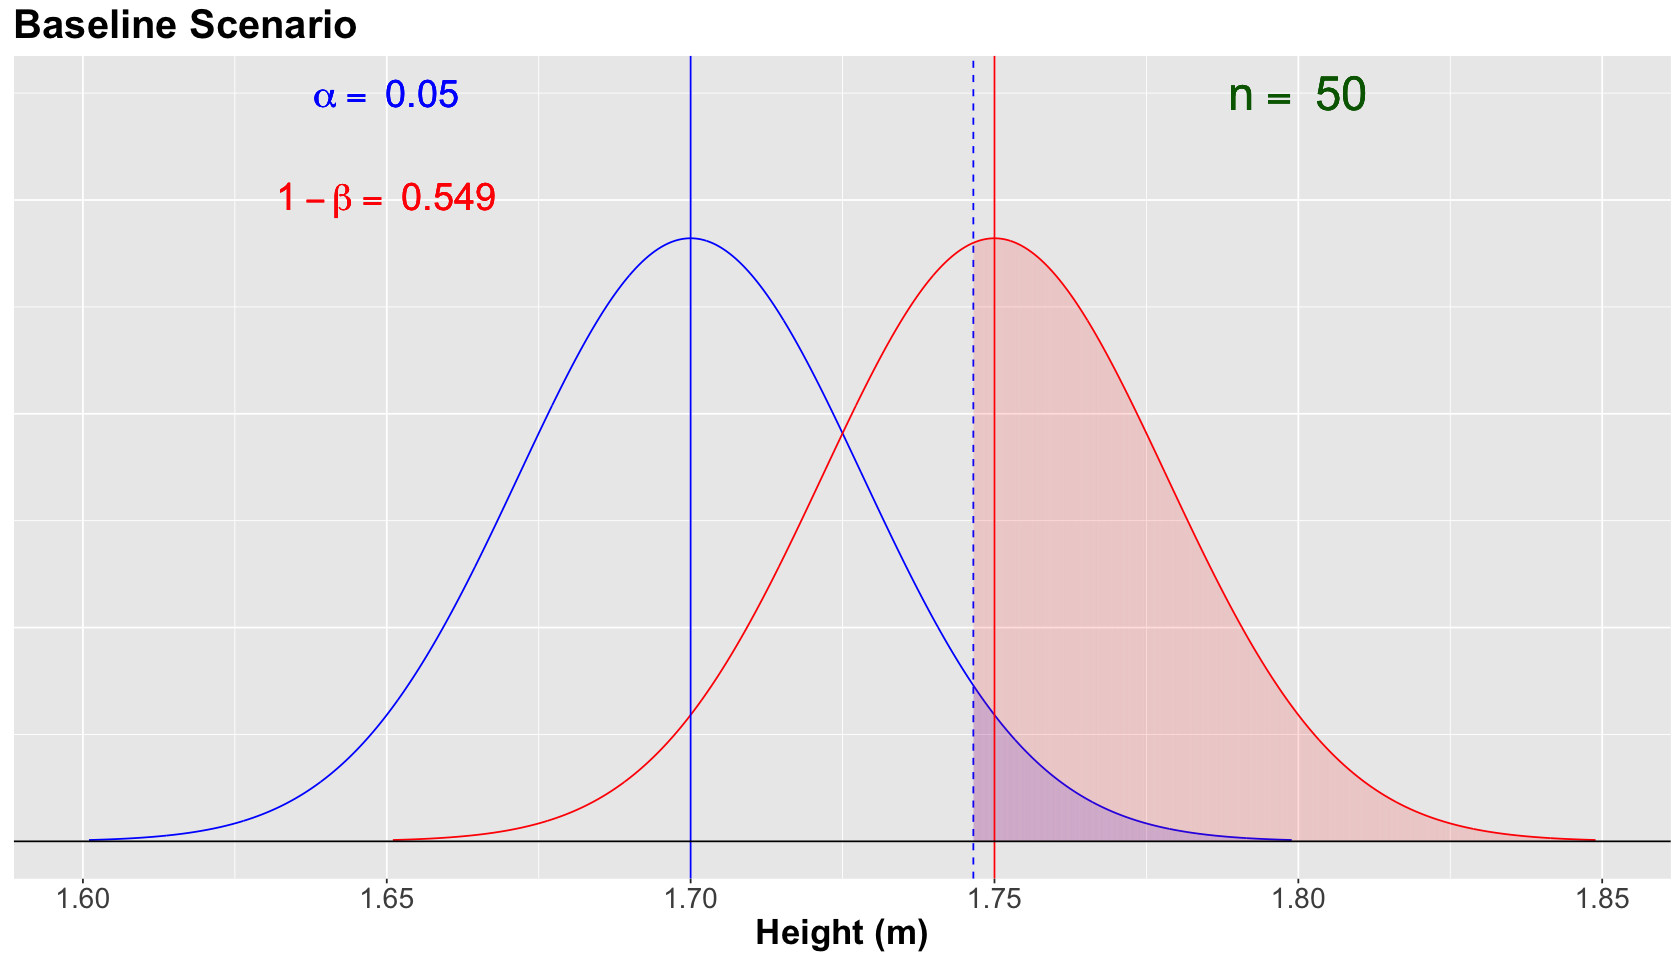

In [19]:
baseline_power <- plotting_power_function(
   mean_null = 1.70, mean_alt = 1.75, sd = 0.2, n = 50, alpha_level = 0.05,
   x_coord = 1.65, x_coord_2 = 1.80,
   y_coord_alpha = 17.5, y_coord_power = 15
  ) + ggtitle("Baseline Scenario")
suppressWarnings(print(baseline_power))

Note that the <font color='blue'>blue</font> vertical solid line denotes the <font color='blue'>null population mean $\mu = 1.70$</font>, whereas the <font color='red'>red</font> vertical solid line denotes the <font color='red'>alternative population mean $\mu = 1.75$</font>. Moreover, the <font color='blue'>blue</font> vertical dashed line is our threshold for the significance level <font color='blue'>$\alpha = 0.05$</font> (our tolerance level to commit Type I error, i.e., the <font color='blue'>shaded blue area under the null curve</font>).

For the scenario above, the power of the test <font color='red'>$1 - \beta  = 0.549$</font> (<font color='red'>shaded red area under the alternative curve</font>) is not too high. This number is critical since we know that <font color='red'>$H_a$ is true in fact</font>. We need to do something to increase the power of our test!

#### Increasing the Sample Size to $n = 100$

$$\color{blue}{H_0: \mu = 1.70}$$
$$\color{red}{H_a: \mu > 1.70}$$

```{attention} 
Assume that <font color='red'>$H_a$ is true in fact for the population</font>.
```

What if we have more budget to double our sample size to $n = 100$? Will this increase the power of our test? Suppose we still have the same <font color='blue'>null</font> and <font color='red'>alternative</font> models for $\bar{X}$ with the same population $\sigma = 0.2$ (**for both models**).

Recall the <font color='red'>alternative model</font> for the sampling distribution of $\bar{X}$ as: 

$$\color{red}{\bar{X} \mathrel{\dot\sim} \mathcal{N} \Bigg( \mu = 1.75, \frac{\sigma}{\sqrt{n}} \Bigg) \quad \text{as} \quad n \rightarrow \infty}$$

versus the <font color='blue'>null model</font>

$$\color{blue}{\bar{X} \mathrel{\dot\sim} \mathcal{N} \Bigg( \mu = 1.70, \frac{\sigma}{\sqrt{n}} \Bigg) \quad \text{as} \quad n \rightarrow \infty}$$

**This will narrow both normal curves,** since the standard deviation of the sampling distribution is $\sigma/\sqrt{n}$. Therefore, the power <font color='red'>$1 - \beta$</font> will increase while holding <font color='blue'>$\alpha = 0.05$</font>.

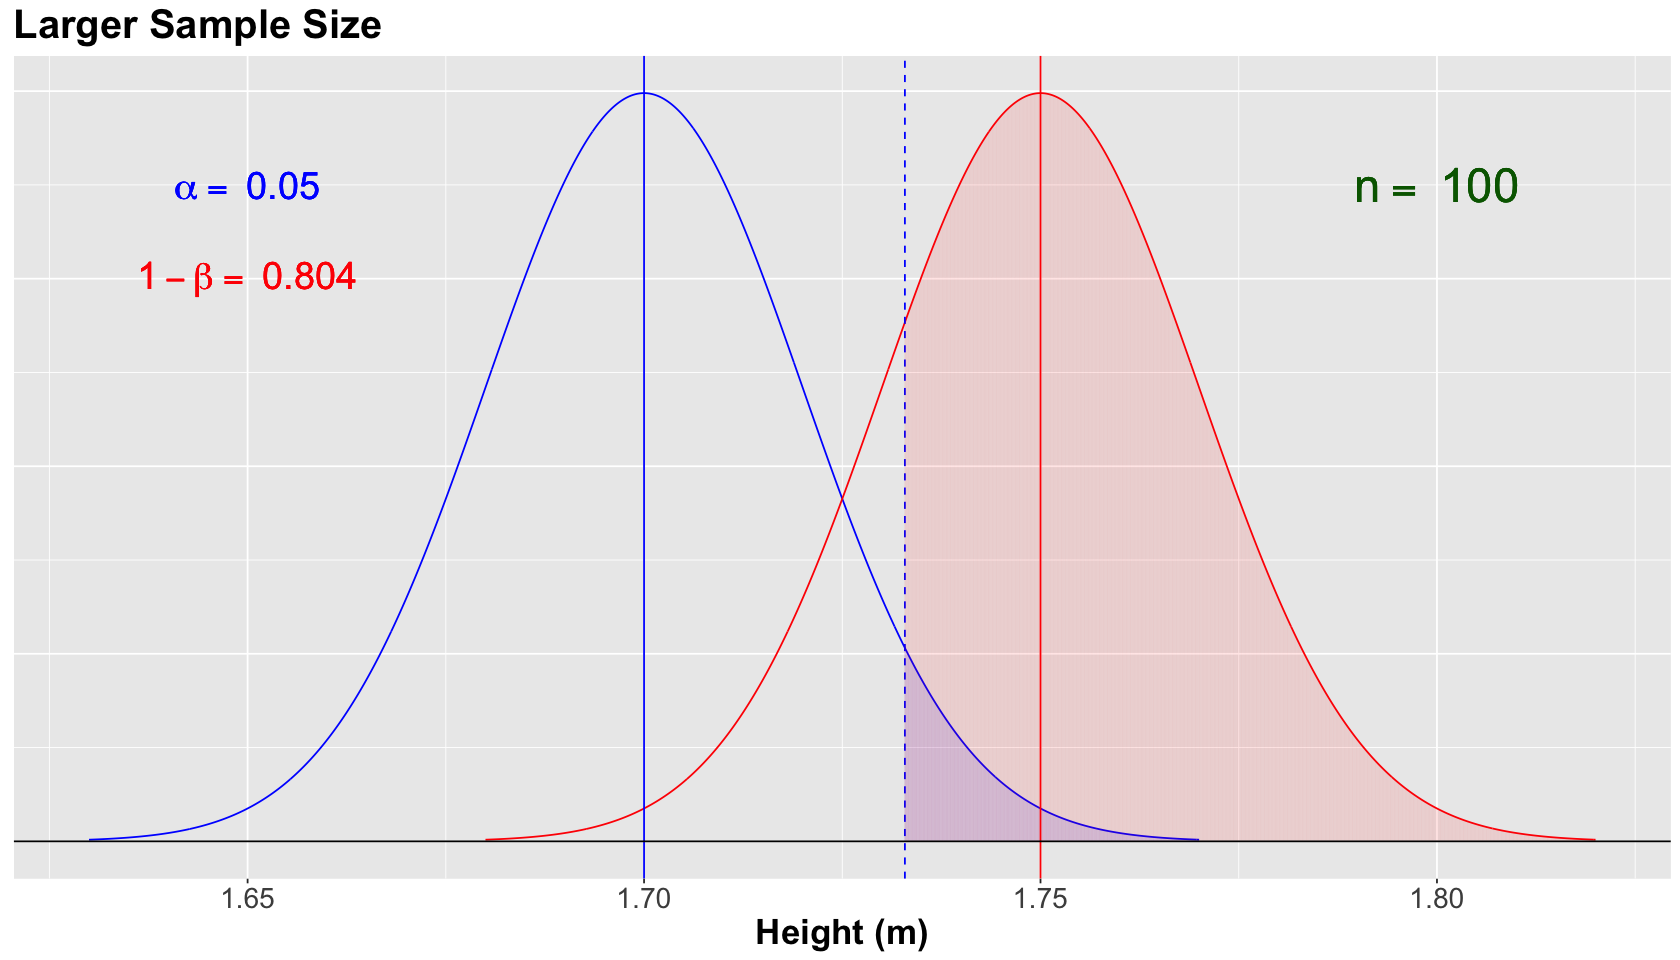

In [20]:
larger_sample_size_n100 <- plotting_power_function(
   mean_null = 1.70, mean_alt = 1.75, sd = 0.2, n = 100, alpha_level = 0.05,
   x_coord = 1.65, x_coord_2 = 1.80,
   y_coord_alpha = 17.5, y_coord_power = 15
  ) + ggtitle("Larger Sample Size")
suppressWarnings(print(larger_sample_size_n100))

The <font color='blue'>blue</font> vertical solid line denotes the <font color='blue'>null population mean $\mu = 1.70$</font>, whereas the <font color='red'>red</font> vertical solid line denotes the <font color='red'>alternative population mean $\mu = 1.75$</font>. Moreover, the <font color='blue'>blue</font> vertical dashed line is our threshold for the significance level <font color='blue'>$\alpha = 0.05$</font> (our tolerance level to commit Type I error, i.e., the <font color='blue'>shaded blue area under the null curve</font>).

For the scenario above, we increased the power of the test to <font color='red'>$1 - \beta  = 0.804$</font> (<font color='red'>shaded red area under the alternative curve</font>). Great!

#### Decreasing the Significance Level to  <font color='blue'>$\alpha = 0.01$</font>

$$\color{blue}{H_0: \mu = 1.70}$$
$$\color{red}{H_a: \mu > 1.70}$$

```{attention} 
Assume that <font color='red'>$H_a$ is true in fact for the population</font>.
```

**With the same previous sample size $n = 100$**, and assuming the same population $\sigma = 0.2$ (**for both models**), suppose we still have the same <font color='blue'>null</font> and <font color='red'>alternative</font> models for $\bar{X}$. Moreover, **what if the research team is stricter in terms of controlling the tolerance to <font color='blue'>type I error</font>?**

```{note}
Even though <font color='red'>$H_a$ is true in fact for the population</font> as in this case, we always have to control <font color='blue'> the significance level $\alpha$</font>! Recall we will not know what is exactly going on with the parameters that govern a population, thus we infer.
```

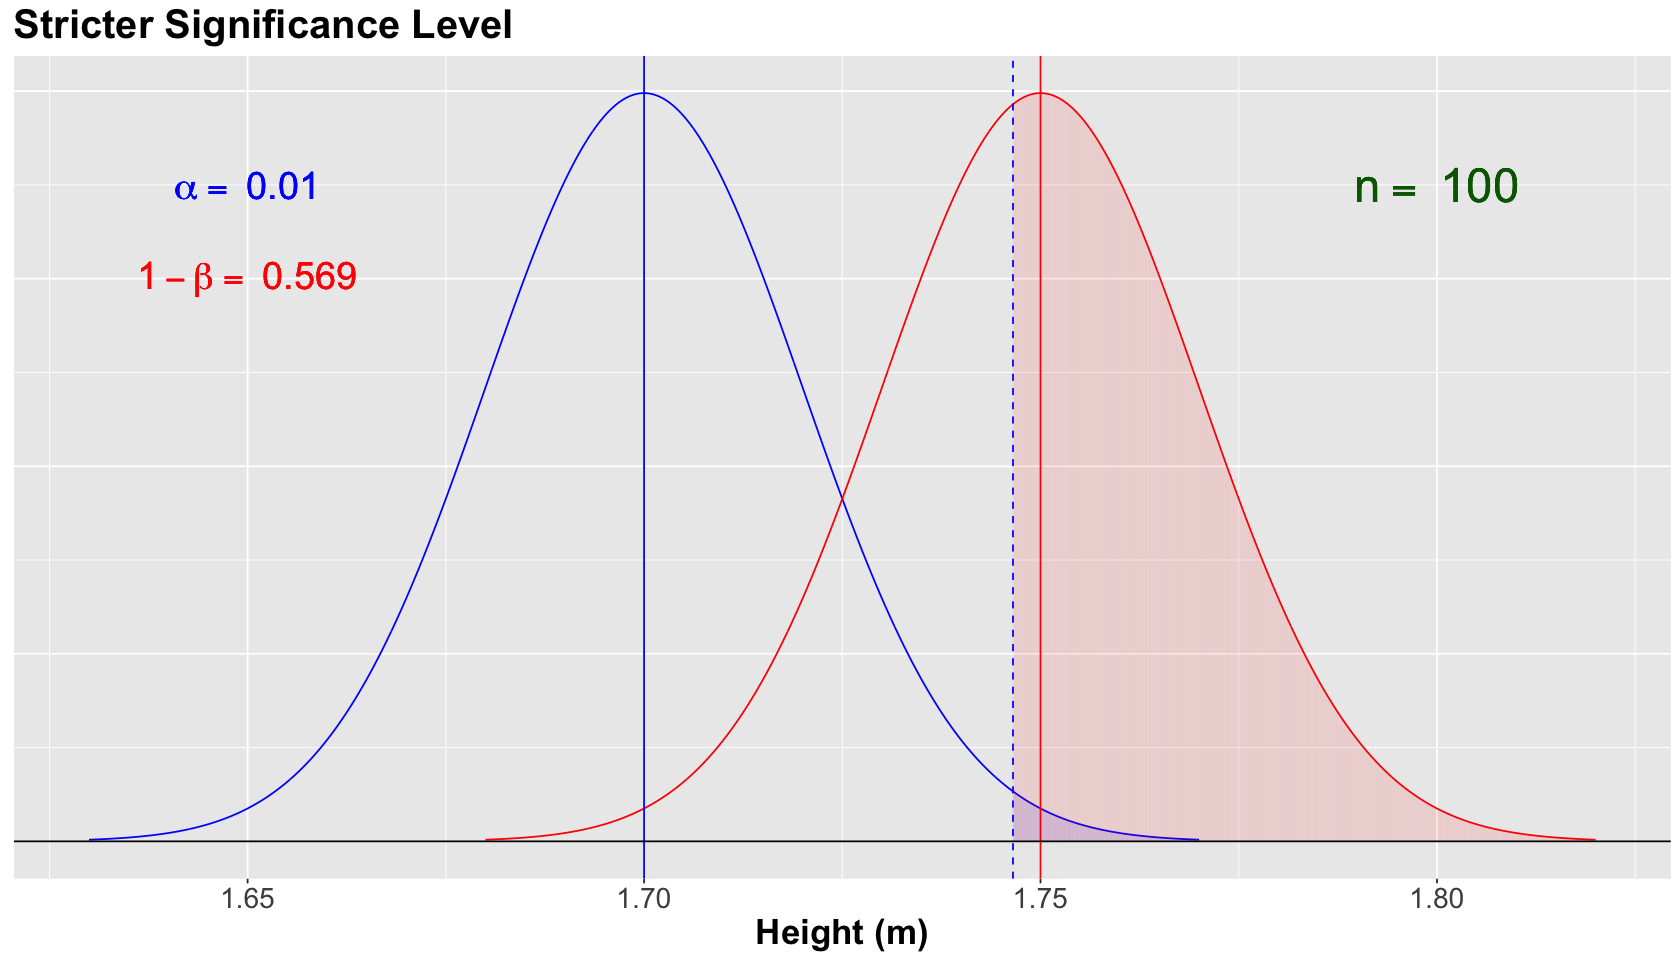

In [21]:
stricter_alpha <- plotting_power_function(
   mean_null = 1.70, mean_alt = 1.75, sd = 0.2, n = 100, alpha_level = 0.01,
   x_coord = 1.65, x_coord_2 = 1.80,
   y_coord_alpha = 17.5, y_coord_power = 15
  ) + ggtitle("Stricter Significance Level")
suppressWarnings(print(stricter_alpha))

The <font color='blue'>blue</font> vertical solid line denotes the <font color='blue'>null population mean $\mu = 1.70$</font>, whereas the <font color='red'>red</font> vertical solid line denotes the <font color='red'>alternative population mean $\mu = 1.75$</font>. Moreover, the <font color='blue'>blue</font> vertical dashed line is our threshold for the significance level <font color='blue'>$\alpha = 0.01$</font> (our tolerance level to commit Type I error, i.e., the <font color='blue'>shaded blue area under the null curve</font>). Note how this vertical dashed line moved more to the right since we are decreasing to <font color='blue'>$\alpha = 0.01$</font>.

For the scenario above, we decreased the power of the test to <font color='red'>$1 - \beta  = 0.569$</font> (<font color='red'>shaded red area under the alternative curve</font>). This is the trade-off for controlling, even more, our type I error.

#### Hold on! What if the <font color='red'>alternative model</font> changes?

$$\color{blue}{H_0: \mu = 1.70}$$
$$\color{red}{H_a: \mu > 1.70}$$

```{attention} 
Assume that <font color='red'>$H_a$ is true in fact for the population</font>.
```

Nonetheless, let us define the <font color='red'>alternative model</font> for the sampling distribution of $\bar{X}$ as: 

$$\color{red}{\bar{X} \mathrel{\dot\sim} \mathcal{N} \Bigg( \mu = 1.78, \frac{\sigma}{\sqrt{n}} \Bigg) \quad \text{as} \quad n \rightarrow \infty}$$

versus the <font color='blue'>null model</font>

$$\color{blue}{\bar{X} \mathrel{\dot\sim} \mathcal{N} \Bigg( \mu = 1.70, \frac{\sigma}{\sqrt{n}} \Bigg) \quad \text{as} \quad n \rightarrow \infty}$$

```{attention} 
Now, <font color='red'>$\mu = 1.78$</font>. Therefore, we are increasing the difference between the means of both models (i.e., the so-called **effect size**).
```
Let us set a population $\sigma = 0.2 \text{ m}$ (**for both models**) and a sample size $n = 100$ with <font color='blue'>$\alpha = 0.01$</font>.

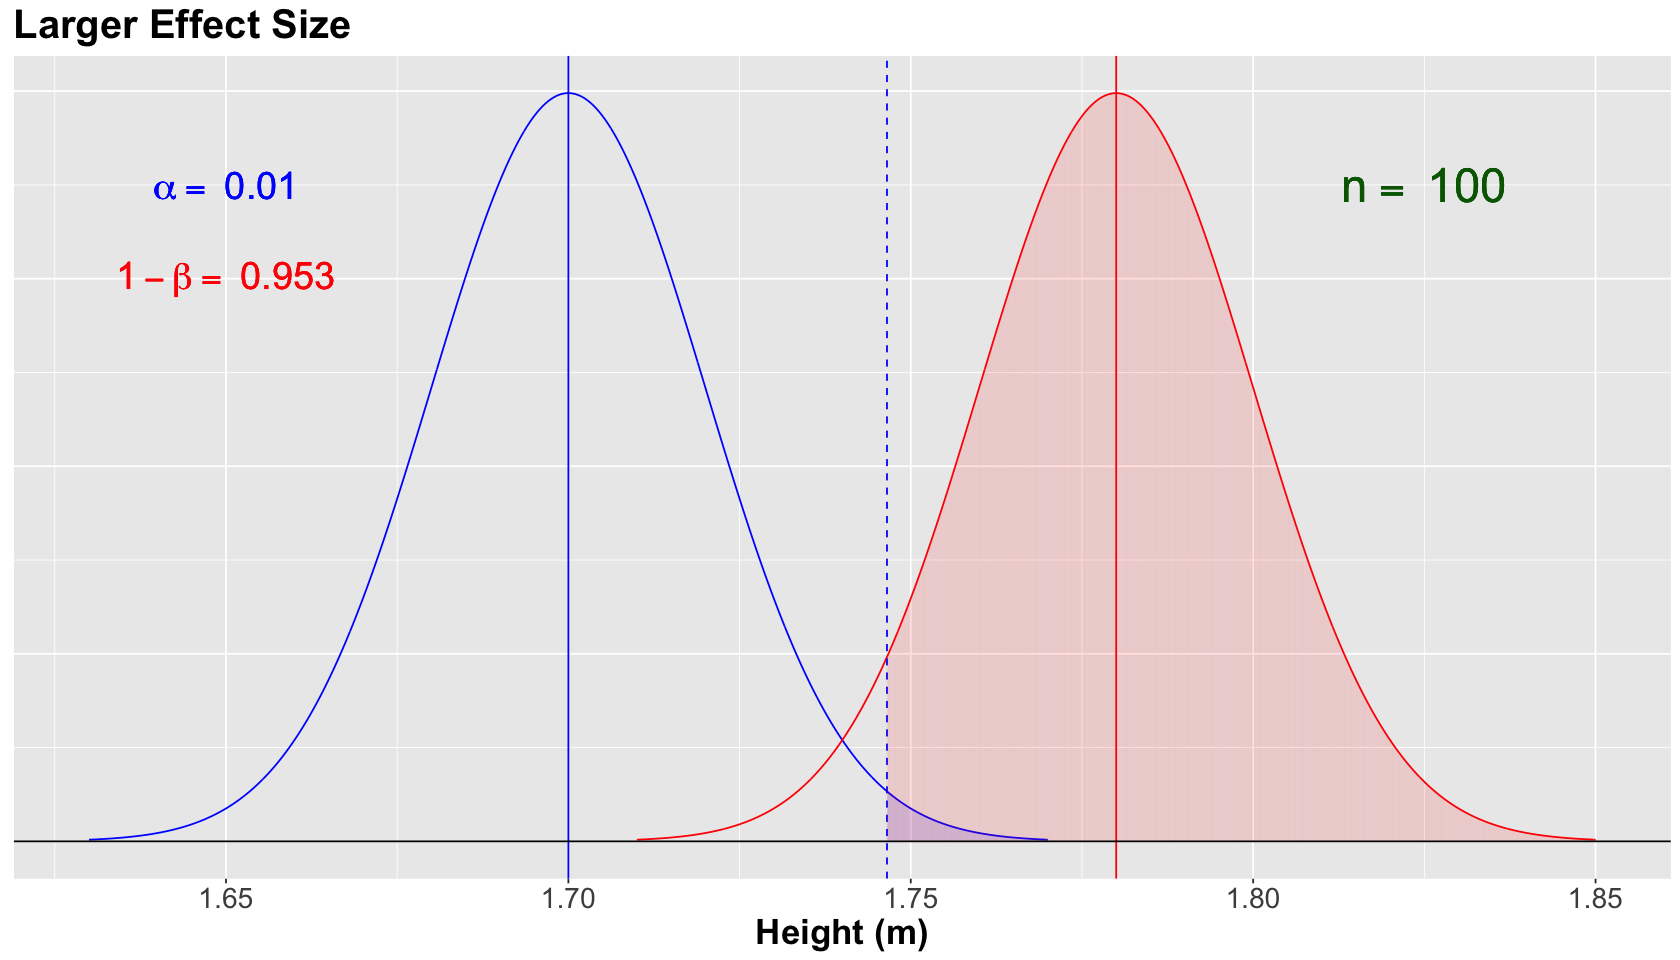

In [22]:
larger_mu_A <- plotting_power_function(
  mean_null = 1.70, mean_alt = 1.78, sd = 0.2, n = 100, alpha_level = 0.01,
  x_coord = 1.65, x_coord_2 = 1.825,
  y_coord_alpha = 17.5, y_coord_power = 15
) + ggtitle("Larger Effect Size")
suppressWarnings(print(larger_mu_A))

The <font color='blue'>blue</font> vertical solid line denotes the <font color='blue'>null population mean $\mu = 1.70$</font>, whereas the <font color='red'>red</font> vertical solid line denotes the <font color='red'>alternative population mean $\mu = 1.78$</font>. Moreover, the <font color='blue'>blue</font> vertical dashed line is our threshold for the significance level <font color='blue'>$\alpha = 0.01$</font> (our tolerance level to commit Type I error, i.e., the <font color='blue'>shaded blue area under the null curve</font>).

For the scenario above, we increase the power of the test to <font color='red'>$1 - \beta  = 0.953$</font> (<font color='red'>shaded red area under the alternative curve</font>). Since the <font color='red'>alternative model</font> got moved more to the right given its <font color='red'>$\mu = 1.78$</font>. **In other words, we have a larger effect size.**

#### Scenario Summary

Let us use `plot_grid()` to summarize our four scenarios so we can have the big picture in this **Power Analysis**. Note how the phenomenon "pulling more than one string" comes into play.

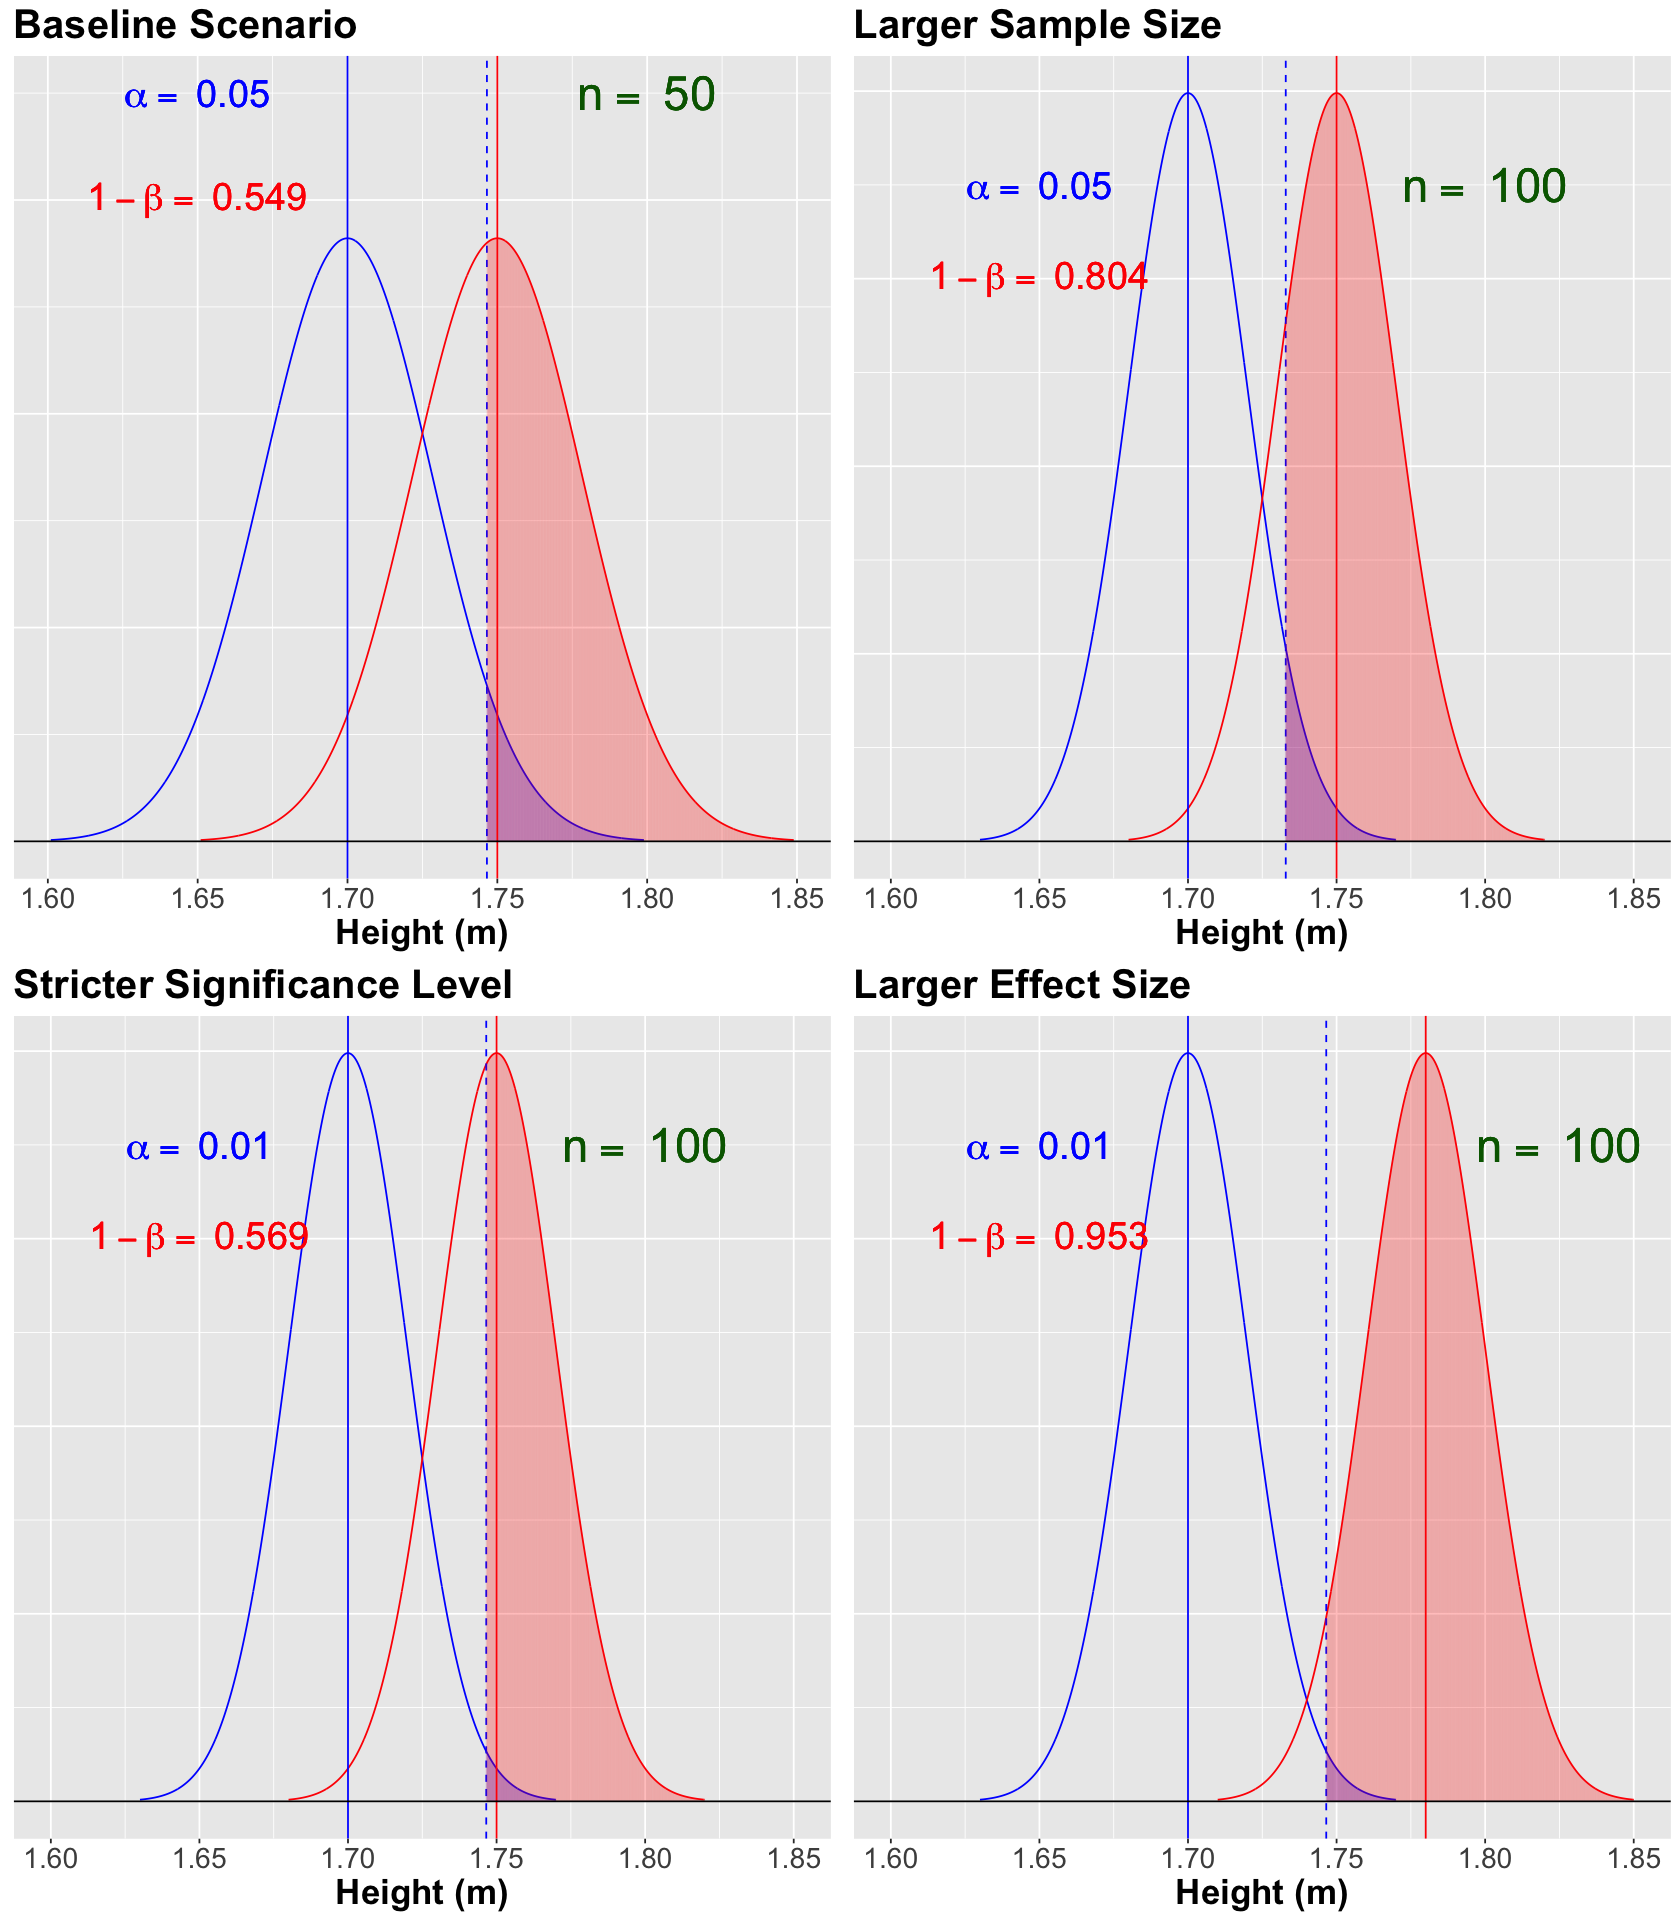

In [23]:
options(repr.plot.height = 16, repr.plot.width = 14)

baseline_power <- baseline_power 
larger_sample_size_n100 <- larger_sample_size_n100 + xlim(c(1.60, 1.85))
stricter_alpha <- stricter_alpha + xlim(c(1.60, 1.85))
larger_mu_A <- larger_mu_A + xlim(c(1.60, 1.85))

suppressWarnings(print(plot_grid(baseline_power, larger_sample_size_n100, stricter_alpha, larger_mu_A)))

## Inflation of Type I Error in Multiple Comparisons

Suppose we run $m$ **independent** tests on the same dataset. Each $i$th test $(i = 1, \dots m)$ has the following probability of committing **Type I error**:

```{math}
\begin{gather*}
E_ i = \text{Committing Type I error in the } i \text{th test} \\
P(E_ i) = \alpha.
\end{gather*}
```

The probability of **NOT committing Type I error** in the $i$th test is the following:

$$P\left(E_ i^c\right) = 1 - \alpha.$$

The **probability of NOT committing Type I error in ALL the $m$ tests** is an **intersection** of complements:

```{math}
\begin{align*}
P\left(E_{1}^c \cap E_{2}^c \cap \dots \cap E_{m}^c \right) &=  P\left(E_{1}^c\right) \times P\left(E_{2}^c\right) \times \dots \times P\left(E_{m}^c\right)\\
& = (1 - \alpha)^m \qquad \qquad \text{by indepedence.}
\end{align*}
```

Finally, the **probability of committing AT LEAST one Type I error in the $m$ tests** is the complement of the previous intersection:

$$P\left[ \left( E_{1}^c \cap E_{2}^c \cap \dots \cap E_{m}^c \right)^c \right] = 1 - (1 - \alpha)^m.$$

The inflated probability corresponds to committing AT LEAST one Type I error in the $m$ tests. We can plot this **theoretical behaviour** by varying $m$ on the $x$-axis as follows:

In [24]:
options(repr.plot.height = 8, repr.plot.width = 14)

x <- 1:400
df <- data.frame(x)
alpha <- 0.05

inflated_error_plot <- ggplot(df, aes(x)) +
  xlim(0, 400) +
  geom_function(fun = function(x) 1 - (1 - alpha)^x, colour = "red") +
  theme(
    plot.title = element_text(size = 24),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21),
  ) +
  ggtitle(expression("Probability of Committing at LEAST one Type I error in the m tests with" ~ alpha ~ "= 0.05")) +
  xlab("m tests") +
  ylab("Probability") +
  scale_x_continuous(breaks = seq(0, 400, 25)) +
  scale_y_continuous(breaks = seq(0, 1, 0.1))

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


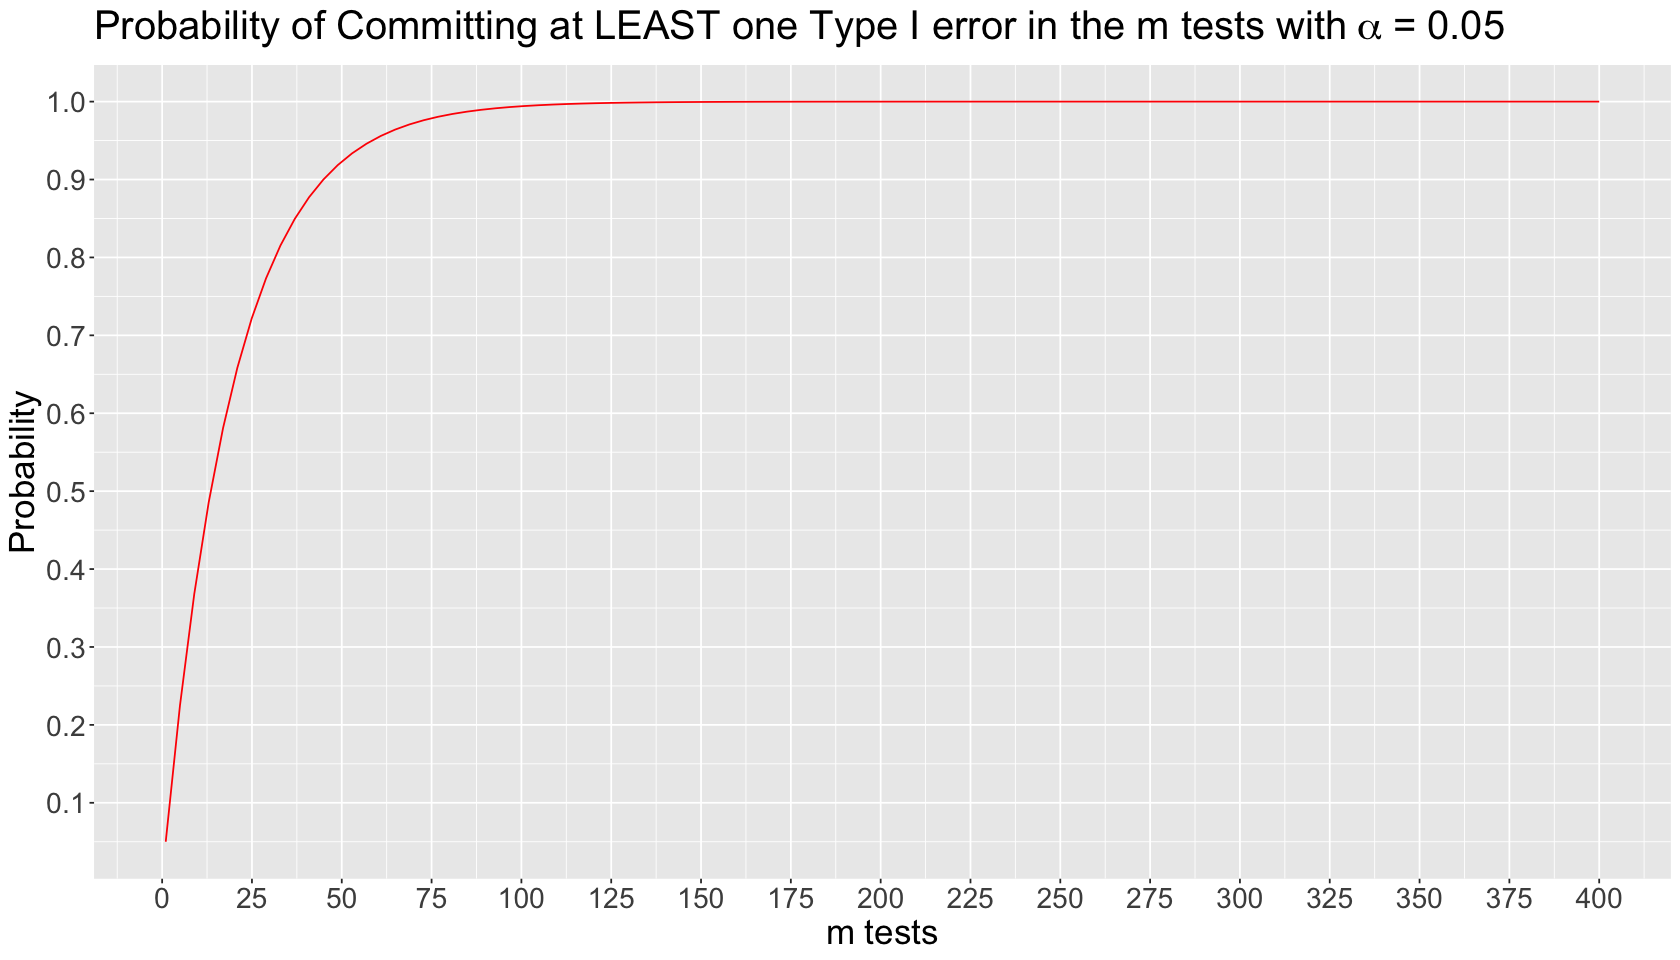

In [25]:
inflated_error_plot

## $p$-hacking

We have to avoid a practice known as $p$-hacking in which we perform many different tests on our data to obtain any significant result to publish. By doing this, multiple testing occurs, which inflates our type I error if we do not control it with some available correction (e.g., Bonferroni correction).

## Simpson's Paradox

Simpson's paradox occurs when we see a trend in aggregated data (between two variables $X$ and $Y$), but this trend reverses when we separate the data into specific groups (i.e., we take into account another variable $Z$).** It was first addressed by Edward Simpson in 1951 in his paper "[The Interpretation of Interaction in Contingency Tables](http://math.bme.hu/~marib/bsmeur/simpson.pdf)